# Predictive Modeling
## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../data/modified_data.csv', index_col=0)
# Shuffle rows
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,Year,Player,Age,Tm,G,TS%,3PAr,FTr,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS,WS/48,3P%,FT%,Pick,GS%,FGA/48,PF/48,MPG,Improvement,Frontcourt,Imprv_prev_year,Tm_WS,Tm_next,Change_team
0,2001.0,Lamar Odom,21,LAC,76.0,0.536,0.242,0.369,11.9,25.0,1.4,3.0,17.8,24.1,6.5,0.111,0.316,0.679,4.0,0.973684,17.703808,3.994358,37.315789,-5.80000,1,3.3,34.6,LAC,True
1,2016.0,D.J. Augustin,28,OKC,62.0,0.575,0.480,0.366,4.4,25.3,1.6,0.3,17.1,18.0,2.6,0.106,0.405,0.805,9.0,0.000000,14.261460,3.463497,19.000000,-1.40000,0,-0.8,61.9,ORL,False
2,2011.0,Gilbert Arenas,29,ORL,70.0,0.471,0.446,0.208,6.1,25.3,2.1,0.9,18.1,24.7,0.5,0.014,0.297,0.784,30.0,0.228571,19.616927,5.024499,25.657143,-0.00303,0,-1.3,54.4,MEM,False
3,2006.0,Matt Carroll,25,CHA,78.0,0.540,0.389,0.353,7.1,4.6,1.9,0.7,8.0,20.8,2.6,0.097,0.389,0.821,61.0,0.076923,17.920000,4.517647,16.346154,2.00000,0,1.9,32.5,CHA,True
4,2010.0,Caron Butler,29,WAS,74.0,0.507,0.138,0.300,9.5,9.2,2.2,0.7,11.9,22.1,3.5,0.061,0.290,0.838,10.0,1.000000,18.127201,3.328782,37.608108,-2.30000,0,-1.0,34.1,DAL,False


In [3]:
# Separate target data
target = data['Improvement']
data.drop('Improvement', axis=1, inplace=True)
# Drop columns that are not going to be used for modeling.
data.drop(['Year','Player','Tm','Tm_next','WS'], axis=1, inplace=True)
# Since a lot of the features are percentages, I think it makes the most sense to scale the data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [4]:
# Create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_data, target.values, random_state=42)

## 2. Regression models
### 2.1 Establish benchmark
In EDA, I saw a clean negative relationship between player improvement and age. I will build a simple linear model using age and use that as the benchmark.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Find the column index of 'Age'
age_col = data.columns.tolist().index('Age')
# Run the simple linear regression model based on age
lm = LinearRegression()
lm.fit(Xtrain[:,age_col].reshape(-1,1), ytrain)
ypred = lm.predict(Xtest[:,age_col].reshape(-1,1))
print('RMSE of simple linear model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of simple linear model is 2.1564883117402265


### 2.2 Linear Models
#### 2.2.1 Linear Regression

In [6]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of linear regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of linear regression model is 1.9511560739912464


In [7]:
# Take a look at coefficients to see which features are most important
print(pd.Series(lm.coef_, index=data.columns))

Age               -3.204844
G                 -1.473186
TS%                0.603900
3PAr              -0.135424
FTr                0.962913
TRB%               1.682731
AST%               1.173016
STL%               0.574408
BLK%               1.052296
TOV%               0.226395
USG%              -1.482357
WS/48             -4.345864
3P%                0.176573
FT%                0.935251
Pick              -0.325538
GS%               -0.655238
FGA/48             1.373464
PF/48             -0.581360
MPG                0.344272
Frontcourt        -0.219830
Imprv_prev_year   -6.171432
Tm_WS             -0.082938
Change_team        0.398152
dtype: float64


The linear regression model reduced the RMSE by 10%. The most important features are age, WS/48(how good a player is), and improvement last year.<br>
Let's try linear models with regularization.
#### 2.2.2 Ridge Regression

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# Grid search alpha and l1_ratio
lm = Ridge(random_state=42)
params = {
    'alpha':[0.01, 0.1, 1, 10]
}
# Write a function that runs GridSearchCv, and output results
def grid_search_cv(regressor, params, Xtrain, ytrain):
    model = GridSearchCV(regressor, params, scoring='neg_mean_squared_error')
    model.fit(Xtrain, ytrain)
    print('Best parameters were', model.best_params_)
    print('Best RMSE was', np.sqrt(-1*model.best_score_))
grid_search_cv(lm, params, Xtrain, ytrain)

Best parameters were {'alpha': 1}
Best RMSE was 1.999525553521209


In [9]:
lm = Ridge(alpha=0.1, random_state=42)
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of Ridge regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of Ridge regression model is 1.9511617026039978


In [10]:
print(pd.Series(lm.coef_, index=data.columns))

Age               -3.202538
G                 -1.473521
TS%                0.571994
3PAr              -0.136580
FTr                0.942096
TRB%               1.662857
AST%               1.152549
STL%               0.565592
BLK%               1.044821
TOV%               0.243955
USG%              -1.425294
WS/48             -4.291855
3P%                0.175364
FT%                0.928733
Pick              -0.325716
GS%               -0.654531
FGA/48             1.324346
PF/48             -0.579759
MPG                0.341579
Frontcourt        -0.219704
Imprv_prev_year   -6.159656
Tm_WS             -0.094518
Change_team        0.398209
dtype: float64


There was almost no difference between the linear regression model and the Ridge regression model.

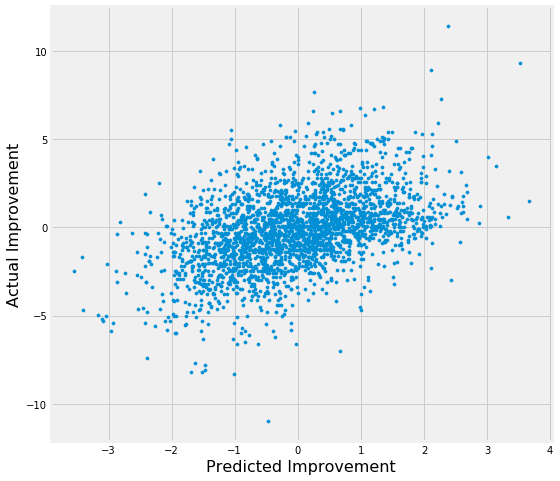

In [11]:
def plot_predict_true(ytest, ypred):
    plt.figure(figsize=(8,8))
    _ = plt.scatter(ypred, ytest, s=10)
    _ = plt.xlabel('Predicted Improvement', fontsize=16)
    _ = plt.ylabel('Actual Improvement', fontsize=16)
plot_predict_true(ytest, ypred)

The predicted space is much tighter than the space of actual values. 
#### 2.2.3 Lasso Regression

In [12]:
from sklearn.linear_model import Lasso
# Grid search alpha and l1_ratio
lm = Lasso(random_state=42)
params = {
    'alpha':[1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1]
}
grid_search_cv(lm, params, Xtrain, ytrain)

Best parameters were {'alpha': 1e-05}
Best RMSE was 1.999555157488054


In [13]:
lm = Lasso(alpha=1e-5, random_state=42)
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of Lasso regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of Lasso regression model is 1.95114663149392


The alpha parameter is very small. There is very little regularization. The Lasso regression model is almost the same as linear regression model.
### 2.3. SVM

In [14]:
from sklearn.svm import SVR
svr = SVR()
params = {
    'C': [1, 10, 100, 1000]
}
grid_search_cv(svr, params, Xtrain, ytrain)

Best parameters were {'C': 100}
Best RMSE was 1.9865706111325192


In [15]:
svr = SVR(C=100)
svr.fit(Xtrain, ytrain)
ypred = svr.predict(Xtest)
print('RMSE of SVM model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of SVM model is 1.9305697136101487


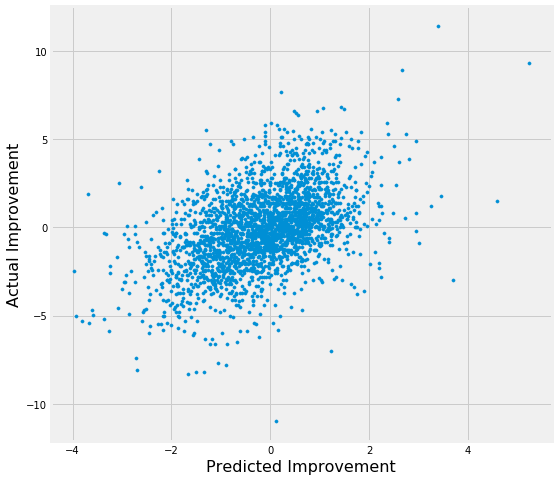

In [16]:
plot_predict_true(ytest, ypred)

RMSE is slightly better than linear models.
### 2.4. Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
params = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 10, 20, 50]
}
grid_search_cv(rf, params, Xtrain, ytrain)

Best parameters were {'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 500}
Best RMSE was 1.9967399963830037


In [18]:
rf = RandomForestRegressor(random_state=42, n_estimators=500, max_features='sqrt', min_samples_split=20)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
print('RMSE of random forest model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of random forest model is 1.9425858829970937


### 2.5 Gradient Boost

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=42, min_samples_split=20)
# Tune max_depth and max_features first
params = {
    'max_depth': [10, 30, 50],
    'max_features': ['sqrt', None]
}
grid_search_cv(gb, params, Xtrain, ytrain)

Best parameters were {'max_depth': 10, 'max_features': 'sqrt'}
Best RMSE was 2.0458620848207376


In [20]:
# Tune learning rate and n_estimators
gb = GradientBoostingRegressor(random_state=42, max_depth=10, max_features='sqrt', min_samples_split=20)
params = {
    'learning_rate': [0.01, 0.025, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 500]
}
grid_search_cv(gb, params, Xtrain, ytrain)

Best parameters were {'learning_rate': 0.01, 'n_estimators': 500}
Best RMSE was 1.9932755411062228


In [21]:
gb = GradientBoostingRegressor(
        random_state=42, max_depth=10, max_features='sqrt', min_samples_split=20,
        learning_rate=0.01, n_estimators=500
     )
gb.fit(Xtrain, ytrain)
ypred = gb.predict(Xtest)
print('RMSE of gradient boost model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of gradient boost model is 1.9440065658034287


It appears that none of the models can reduce RMSE to below 1.9. Players' improvement still has a lot of variance that cannot be predicted using the available features in this dataset.<br>
Maybe it is more useful to use classification models to predict who were most likely to improve.

## 3. Using classification models

In [5]:
# Transform the target values into classes
ytrain_class = (ytrain >= 0).astype(int)
ytest_class = (ytest >= 0).astype(int)

### 3.1 Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
# Write a function a run gridsearchcv
def grid_search_cv_class(clf, params, Xtrain, ytrain):
    # Use log loss as evaluation metric because 
    # probabilities are going to be more important than the class prediction.
    model = GridSearchCV(clf, params, scoring='neg_log_loss', n_jobs=-1)
    model.fit(Xtrain, ytrain)
    print('Best parameters were', model.best_params_)
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'C': 10, 'penalty': 'l2'}


In [8]:
from sklearn.metrics import classification_report
logreg = LogisticRegression(C=10, penalty='l2', random_state=42)
logreg.fit(Xtrain, ytrain_class)
coefs = pd.Series(logreg.coef_.reshape(-1), index=data.columns)
print(coefs)

Age               -2.816447
G                 -1.716723
TS%               -0.464002
3PAr               0.153580
FTr                1.104541
TRB%               1.909763
AST%               0.818055
STL%               0.588235
BLK%               0.906347
TOV%               0.511042
USG%              -1.033849
WS/48             -4.454501
3P%                0.153864
FT%                0.955206
Pick              -0.296602
GS%               -0.543613
FGA/48             1.453904
PF/48             -0.816098
MPG                0.434740
Frontcourt        -0.174526
Imprv_prev_year   -3.933800
Tm_WS              0.297544
Change_team        0.330259
dtype: float64


In [9]:
# Model evaluation using the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def model_evaluation(model, Xtest, ytest):
    ypred = model.predict(Xtest)
    print('Accuracy of test set was', accuracy_score(ytest, ypred))
    print("\n")
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    print('True Negative = {}\tFalse Positive = {}\nFalse Negative = {}\tTrue Positive={}'
          .format(tn,fp,fn,tp))
    print("\n")
    print(classification_report(ytest, ypred))
model_evaluation(logreg, Xtest, ytest_class)

Accuracy of test set was 0.6718929254302103


True Negative = 921	False Positive = 421
False Negative = 437	True Positive=836


             precision    recall  f1-score   support

          0       0.68      0.69      0.68      1342
          1       0.67      0.66      0.66      1273

avg / total       0.67      0.67      0.67      2615



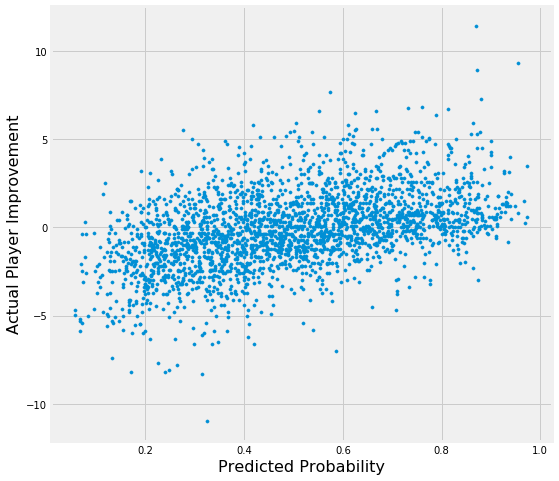

In [10]:
# Plot the predicted probability and true values
def plot_prob_value(model, Xtest, ytest):
    ypred = model.predict_proba(Xtest)[:,1]
    plt.figure(figsize=(8,8))
    _ = plt.scatter(ypred, ytest, s=10)
    _ = plt.xlabel('Predicted Probability', fontsize=16)
    _ = plt.ylabel('Actual Player Improvement', fontsize=16)
plot_prob_value(logreg, Xtest, ytest)

### 3.2 SVM

In [11]:
from sklearn.svm import SVC
clf = SVC(random_state=42, probability=True)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'gamma': [1e-4, 0.001, 0.01, 0.1, 1, 10]
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'C': 10000, 'gamma': 0.001}


In [12]:
svc = SVC(random_state=42, probability=True, C=10000, gamma=0.001)
svc.fit(Xtrain, ytrain_class)
model_evaluation(svc, Xtest, ytest_class)

Accuracy of test set was 0.6730401529636711


True Negative = 936	False Positive = 406
False Negative = 449	True Positive=824


             precision    recall  f1-score   support

          0       0.68      0.70      0.69      1342
          1       0.67      0.65      0.66      1273

avg / total       0.67      0.67      0.67      2615



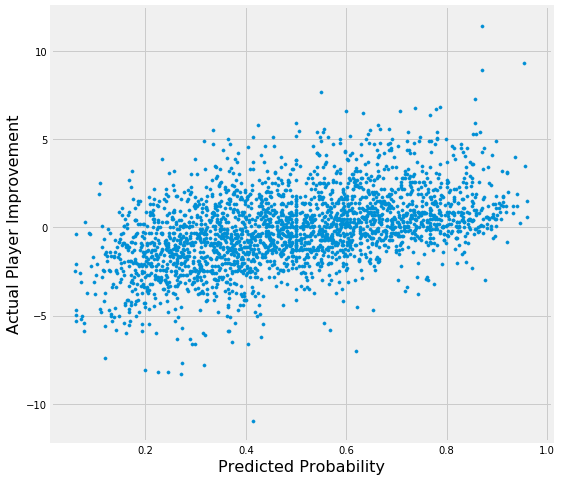

In [13]:
plot_prob_value(svc, Xtest, ytest)

Very similar performances between logistic regression and SVM.
### 3.3 Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20],
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 200}


In [15]:
rf = RandomForestClassifier(
                   n_estimators=200, max_depth=10, min_samples_split=20,
                   random_state=42)
rf.fit(Xtrain, ytrain_class)
model_evaluation(svc, Xtest, ytest_class)

Accuracy of test set was 0.6730401529636711


True Negative = 936	False Positive = 406
False Negative = 449	True Positive=824


             precision    recall  f1-score   support

          0       0.68      0.70      0.69      1342
          1       0.67      0.65      0.66      1273

avg / total       0.67      0.67      0.67      2615



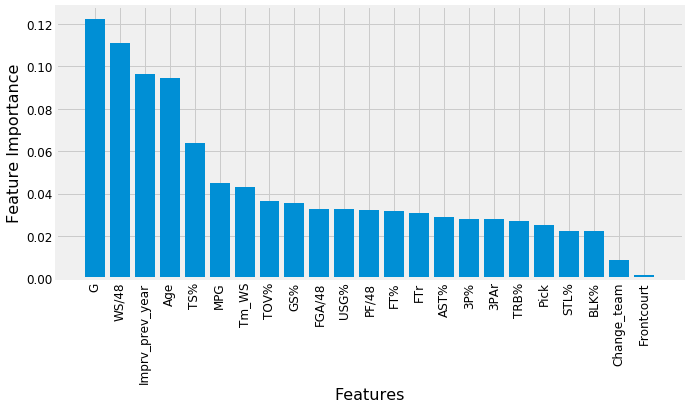

In [16]:
# Plot feature importances.
imp = pd.Series(rf.feature_importances_, index=data.columns)
imp = imp.sort_values(ascending=False)
plt.figure(figsize=(10,5))
_ = plt.bar(range(len(imp)), imp)
_ = plt.xticks(range(len(imp)), imp.index, rotation=90)
_ = plt.xlabel('Features', fontsize=16)
_ = plt.ylabel("Feature Importance", fontsize=16)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

### 3.4 Gradient Boost

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
# Use some tuned parameters from random forest, only tune learning rate and n_estimators
clf = GradientBoostingClassifier(
                    min_samples_split=20, max_depth=10,
                    max_features='sqrt', random_state=42)
params = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [25, 50, 100, 200],
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'learning_rate': 0.05, 'n_estimators': 50}


In [18]:
gb = GradientBoostingClassifier(
                    min_samples_split=20, max_depth=10,
                    max_features='sqrt', random_state=42,
                    learning_rate=0.05, n_estimators=50)
gb.fit(Xtrain, ytrain_class)
model_evaluation(svc, Xtest, ytest_class)

Accuracy of test set was 0.6730401529636711


True Negative = 936	False Positive = 406
False Negative = 449	True Positive=824


             precision    recall  f1-score   support

          0       0.68      0.70      0.69      1342
          1       0.67      0.65      0.66      1273

avg / total       0.67      0.67      0.67      2615



The random forest and gradient boost models had the same performances as SVM.
### 3.5 Voting Model

In [19]:
from sklearn.ensemble import VotingClassifier
# Make a weights matrix
weights = [[int(x) for x in list("{0:0b}".format(i).zfill(4))] for i in range(1, 2**4)]
print('Weights matrix is', weights)
# Use CV to figure which models to use in the ensumble model
clf = VotingClassifier(
    estimators=[('logreg', logreg), ('svc', svc), ('rf', rf), ('gb', gb)],
    voting='soft')
params = {'weights': weights}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Weights matrix is [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]
Best parameters were {'weights': [1, 1, 0, 1]}


In [20]:
voting = VotingClassifier(
    estimators=[('logreg', logreg), ('svc', svc), ('gb', gb)],
    voting='soft', weights = [1,1,1])
voting.fit(Xtrain, ytrain_class)
model_evaluation(voting, Xtest, ytest_class)

Accuracy of test set was 0.6695984703632887


True Negative = 921	False Positive = 421
False Negative = 443	True Positive=830


             precision    recall  f1-score   support

          0       0.68      0.69      0.68      1342
          1       0.66      0.65      0.66      1273

avg / total       0.67      0.67      0.67      2615



/Users/zhenfengliu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


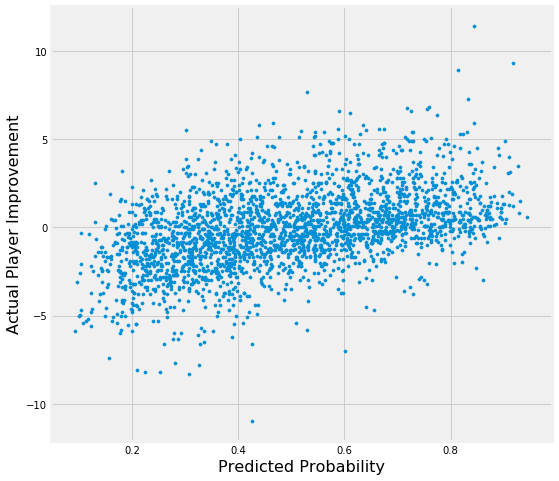

In [21]:
plot_prob_value(voting, Xtest, ytest)

### 3.6 ROC curve

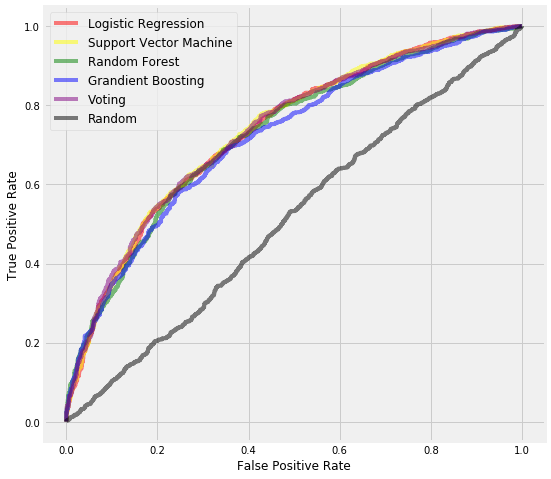

In [22]:
# Plot the precision-recall curve of different models on the test set.
from sklearn.metrics import roc_curve
models = [logreg, svc, rf, gb, voting]
labels = ['Logistic Regression', 'Support Vector Machine',
          'Random Forest', 'Grandient Boosting', 'Voting']
colors = ['red', 'yellow', 'green', 'blue', 'purple']
plt.figure(figsize=(8,8))
for index, model in enumerate(models):
    ypred_prob = model.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest_class, ypred_prob)
    _ = plt.step(fpr, tpr, color=colors[index], alpha=0.5, where='post', label=labels[index])
random = np.random.rand(len(ytest))
fpr, tpr , _ = roc_curve(ytest_class, random)
_ = plt.step(fpr, tpr, color='k', alpha=0.5, where='post', label='Random')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.legend(fontsize=12)

In this problem, we want the false positive rate to be lower. In other words, it is OK to have false negatives (miss some improved players), since a team can only have a limited number of players. But it is really bad to have false positives, because acquiring that player probably means loss of value for the team.

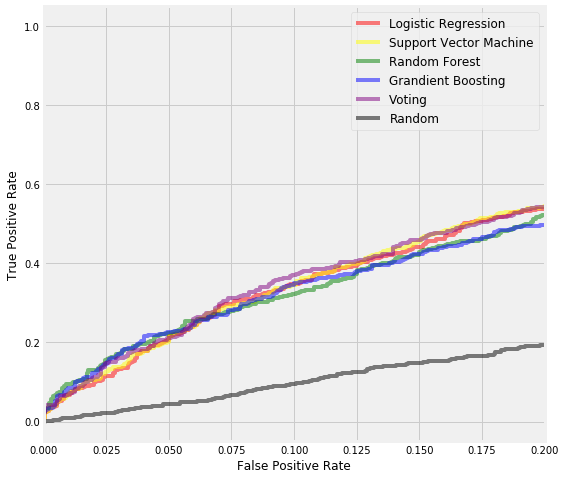

In [23]:
# Re-do the roc curve, but zoom in for false positive rate < 0.2
models = [logreg, svc, rf, gb, voting]
labels = ['Logistic Regression', 'Support Vector Machine',
          'Random Forest', 'Grandient Boosting', 'Voting']
colors = ['red', 'yellow', 'green', 'blue', 'purple']
plt.figure(figsize=(8,8))
for index, model in enumerate(models):
    ypred_prob = model.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest_class, ypred_prob)
    _ = plt.step(fpr, tpr, color=colors[index], alpha=0.5, where='post', label=labels[index])
random = np.random.rand(len(ytest))
fpr, tpr , _ = roc_curve(ytest_class, random)
_ = plt.step(fpr, tpr, color='k', alpha=0.5, where='post', label='Random')
_ = plt.xlim([0, 0.2])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.legend(fontsize=12)

It seems like the voting model was on or near the top in most cases. But the differences between models were very very small.<br>